In [78]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
from data_retrieval.data_config import DATA_DIR


""" warning: the following function has been modified to remove east-west periodicity
    in the grid so that the plot looks neater (that way we don't need to visualize) 
    edges going across the entire map. Thus the get_neighbors function here is different
    than what is actually used to generate adjacencies. 
 """
def get_neighbors(base_rows, base_cols, i, j, method, scale=1):
    if type(scale) != int: raise ValueError("scale must be int")
    
    neighbors = []

    if method == "grid" or method == "dense_grid":
        directions = [(-scale, 0), (scale, 0), (0, -scale), (0, scale)]
        if method == "dense_grid":
            directions += [(-scale, -scale), (-scale, scale), (scale, -scale), (scale, scale)]

        for di, dj in directions:
            neighbor_row = i + di
            neighbor_col = (j + dj)
            if 0 <= neighbor_row < base_rows and 0 <= neighbor_col < base_cols:
                neighbors.append((neighbor_row, neighbor_col))

    return neighbors


def construct_adjacency_list_core(grid_size, method="grid", scales=None, origins=None, verbose=False):
    """
    Helper function: generates the adjacency list for a 24x72 grid of nodes.

    Params:
        method (str): base grid method. Options:
            "grid": connect each node to its 4 up-down-left-right neighbors.
            "dense_grid": connect each node to its 8 neighbors (including diagonals).
        scales (list of int): list of scales for generating downscaled grids. Each scale indicates the reduction factor.
        origins (list of tuple): list of origin tuples (row, col) for each downscaled grid. Should match the length of scales.

    Returns:
        np.array: adjacency list of shape (2, num_edges) 
    """
    rows, cols = grid_size
    adjacency_list = []

    if not scales:
        if origins: 
            raise ValueError("Cannot set `origins` if your scale is 1")
        scales = [1]

    if not origins:
        origins = [(0,0) for i in range(len(scales))]

    if len(scales) != len(origins):
            raise ValueError("`scales` and `origins` must have the same length.")

    for scale, origin in zip(scales, origins):
        for i in range(origin[0], rows, scale):
            for j in range(origin[1], cols, scale):
                curr_index = i * cols + j 

                neighbors = get_neighbors(rows, cols, i, j, method, scale=scale)
                if verbose: print(f"node {i,j} has neighbors {neighbors}")
                for neighbor_i, neighbor_j in neighbors:
                    neighbor_index = neighbor_i * cols + neighbor_j 
                    if verbose: print(f"appending {(curr_index, neighbor_index)}")
                    adjacency_list.append((curr_index, neighbor_index))

    adj_t = np.array(adjacency_list).T
    return adj_t


def construct_adjacency_list(method):
    """ 
    Wrapper function for constructing adjacency list with some presets
    """
    grid_size = (24, 72)

    if method == "simple_grid": 
        return construct_adjacency_list_core(grid_size, method="grid", scales=[1], origins=[(0,0)])
    
    elif method == "simple_grid_dense":
        return construct_adjacency_list_core(grid_size, method="dense_grid", scales=[1], origins=[(0,0)])

    elif method == "multimesh1":
        return construct_adjacency_list_core(grid_size, method="dense_grid", 
                                            scales=[1, 3, 6], origins=[(0,0), (1,1), (4,1)])
    
    else:
        raise NotImplementedError(f"That adjacency method has not been implemented!\
             Current settings: simple_grid, simple_grid_dense, multimesh1 ")


def plot_edges(adjacency_list, data, linewidth=1, rows=24, cols=72):
    # Generate coordinates for each node in the grid
    y, x = np.meshgrid(range(rows), range(cols), indexing='ij')
    node_coords = np.vstack([x.ravel(), y.ravel()]).T  # Shape (num_nodes, 2)

    # Identify valid nodes (not NaN)
    valid_nodes = ~np.isnan(data.ravel())

    # Plot edges for each scale
    colors = plt.cm.Spectral(np.linspace(0,1,10))

    scale_edges = adjacency_list.T

    # Filter edges based on valid nodes
    valid_edges = scale_edges[
        valid_nodes[scale_edges[:, 0]] & valid_nodes[scale_edges[:, 1]]
    ]

    # Plot edges for the current scale
    for edge in valid_edges:
        x_coords = node_coords[edge, 0]
        y_coords = node_coords[edge, 1]
        plt.plot(x_coords, y_coords, color="k", linewidth=linewidth)

def plot_edges_ax(ax, adjacency_list, data, linewidth=1, rows=24, cols=72):
    # Generate coordinates for each node in the grid
    y, x = np.meshgrid(range(rows), range(cols), indexing='ij')
    node_coords = np.vstack([x.ravel(), y.ravel()]).T  # Shape (num_nodes, 2)

    # Identify valid nodes (not NaN)
    valid_nodes = ~np.isnan(data.ravel())

    # Plot edges for each scale
    colors = plt.cm.Spectral(np.linspace(0,1,10))

    scale_edges = adjacency_list.T

    # Filter edges based on valid nodes
    valid_edges = scale_edges[
        valid_nodes[scale_edges[:, 0]] & valid_nodes[scale_edges[:, 1]]
    ]

    # Plot edges for the current scale
    for edge in valid_edges:
        x_coords = node_coords[edge, 0]
        y_coords = node_coords[edge, 1]
        ax.plot(x_coords, y_coords, color="k", linewidth=linewidth)


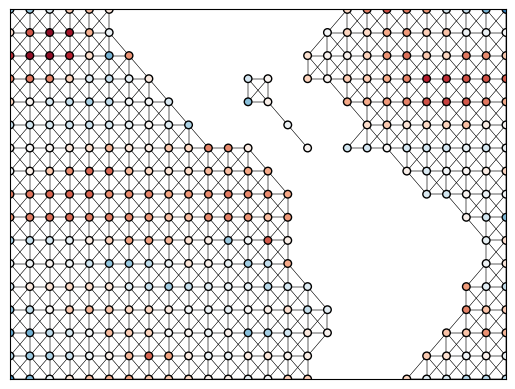

In [69]:
ds = xr.open_dataset(osp.join(DATA_DIR, "CMIP/raw/CMIP_merged.nc"))
data = ds.sst.isel(simulation_id=0, time=200).data
adjacency_list = construct_adjacency_list("simple_grid_dense")

rows, cols = 24, 72
y, x = np.meshgrid(range(rows), range(cols), indexing='ij')
node_coords = np.vstack([x.ravel(), y.ravel()]).T  # Shape (num_nodes, 2)

plot_edges(adjacency_list, data, linewidth=0.25)
# Plot nodes
colors = data.ravel()[valid_nodes]
plt.scatter(node_coords[valid_nodes, 0], node_coords[valid_nodes, 1], 
            c=colors, s=30, zorder=2, vmin=-3, vmax=3, cmap="RdBu_r", edgecolor="k")

# zoom in 
plt.xlim([5, 30])
plt.ylim([4, 20])
plt.xticks([])
plt.yticks([])
plt.savefig("figures/naive_grid_adjacency.jpg", dpi=300, bbox_inches='tight')

([], [])

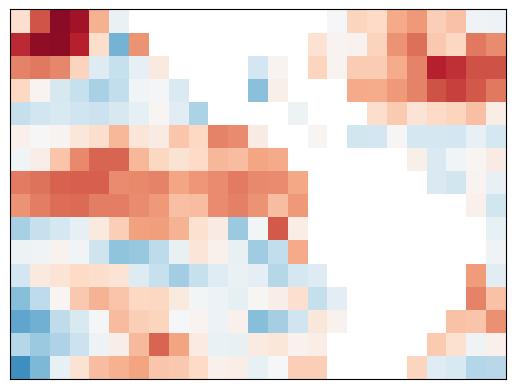

In [29]:
plt.pcolormesh(data, vmin=-3, vmax=3, cmap="RdBu_r")
plt.xlim([5, 30])
plt.ylim([4, 20])
plt.xticks([])
plt.yticks([])

In [66]:
def tally_edges_per_node(adjacency, valid_nodes): 
    tally = []
    nodes = np.arange(0, 24*72)
    for i in nodes[valid_nodes]: 
        tally.append(np.sum(adjacency.flatten() == i))
    return np.array(tally)

In [67]:
valid_nodes = ~np.isnan(data.ravel())

edges_per_node = tally_edges_per_node(construct_adjacency_list("multimesh1"), valid_nodes)


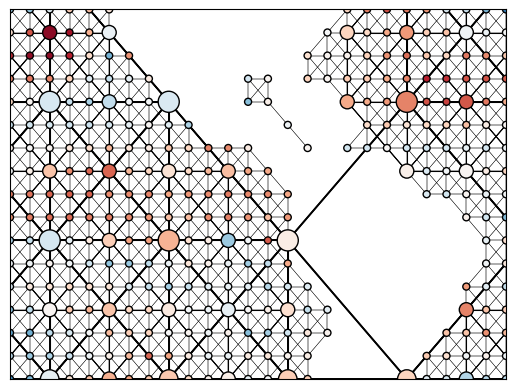

In [73]:
plot_edges(construct_adjacency_list_core((24, 72), method="dense_grid", scales=[1], origins=[(0,0)]), data, linewidth=0.25)
plot_edges(construct_adjacency_list_core((24, 72), method="dense_grid", scales=[3], origins=[(1,1)]), data, linewidth=0.75)
plot_edges(construct_adjacency_list_core((24, 72), method="dense_grid", scales=[6], origins=[(4,1)]), data, linewidth=1.25)

rows, cols = 24, 72
y, x = np.meshgrid(range(rows), range(cols), indexing='ij')
node_coords = np.vstack([x.ravel(), y.ravel()]).T  # Shape (num_nodes, 2)
colors = data.ravel()[valid_nodes]
plt.scatter(node_coords[valid_nodes, 0], node_coords[valid_nodes, 1], 
            c=colors, s=(edges_per_node**2) / 10, zorder=2, vmin=-3, vmax=3, cmap="RdBu_r", edgecolor="k")

plt.xlim([5, 30])
plt.ylim([4, 20])
plt.xticks([])
plt.yticks([])
plt.savefig("figures/multimesh_adjacency.jpg", dpi=300, bbox_inches='tight')

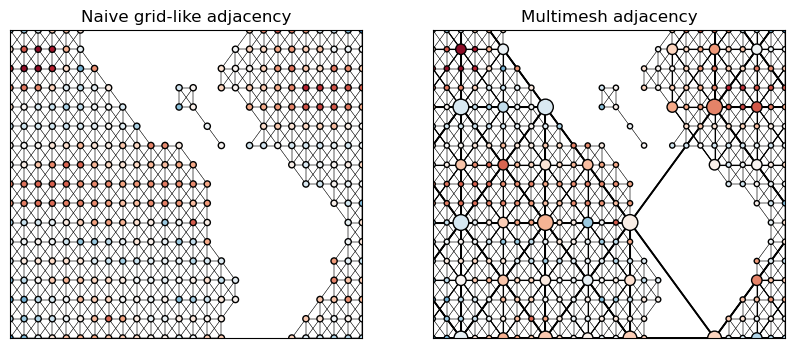

In [87]:
rows, cols = 24, 72
y, x = np.meshgrid(range(rows), range(cols), indexing='ij')
node_coords = np.vstack([x.ravel(), y.ravel()]).T  # Shape (num_nodes, 2)
colors = data.ravel()[valid_nodes]


fig, (ax1, ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2, sharey=True)

plot_edges_ax(ax1, construct_adjacency_list("simple_grid_dense"), data, linewidth=0.25)
ax1.scatter(node_coords[valid_nodes, 0], node_coords[valid_nodes, 1], 
            c=colors, s=20, zorder=2, vmin=-3, vmax=3, cmap="RdBu_r", edgecolor="k")

plot_edges_ax(ax2, construct_adjacency_list_core((24, 72), method="dense_grid", scales=[1], origins=[(0,0)]), data, linewidth=0.25)
plot_edges_ax(ax2, construct_adjacency_list_core((24, 72), method="dense_grid", scales=[3], origins=[(1,1)]), data, linewidth=0.75)
plot_edges_ax(ax2, construct_adjacency_list_core((24, 72), method="dense_grid", scales=[6], origins=[(4,1)]), data, linewidth=1.25)

ax2.scatter(node_coords[valid_nodes, 0], node_coords[valid_nodes, 1], 
            c=colors, s=(edges_per_node**2) / 18, zorder=2, vmin=-3, vmax=3, cmap="RdBu_r", edgecolor="k")

for ax in [ax1, ax2]:
    ax.set_xlim([5, 30])
    ax.set_ylim([4, 20])
    ax.set_xticks([])
    ax.set_yticks([])

ax1.set_title("Naive grid-like adjacency")
ax2.set_title("Multimesh adjacency")

plt.savefig("figures/adjacency_comparison.jpg", dpi=300, bbox_inches='tight')